In [14]:
import os 
import IPython.display as ipd
import numpy as np
import librosa
import librosa.display
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
import pickle
import hashlib

### Load Datasets

In [15]:
def get_files(dir_path):
    files = []
    for entry in os.scandir(dir_path):
        if entry.name.endswith('.wav'):
            path = os.path.join(dir_path,entry.name)
            files.append(path)
    return files
        
def get_file_name(file):
    name = file.split('\\')
    return name[-1][0:-4]

def get_answers(targets, queries):
    answers = dict()
    for query in queries:
        query_name = get_file_name(query)
        for target in targets:
            target_name = get_file_name(target)
            if target_name in query_name:
                answers.update({query_name: target_name})    
    return answers

def play_audios(files, max_play=5):
    for i, f in enumerate(files):
        ipd.display(ipd.Audio(f))
        if(i == max_play-1):
            break
    

In [16]:
targetDir = 'database_recordings'
queryDir = 'query_recordings'
fingerprintDir = 'fingerprint'
evaluationDir = 'evaluation'
        
targets = get_files(targetDir)
queries = get_files(queryDir)

answers = get_answers(targets, queries)
        
play_audios(targets, max_play=1)
play_audios(queries, max_play=1)

answers

{'pop.00085-snippet-10-20': 'pop.00085'}

### Contellation Map Generation Function

In [17]:
min_distance = 8
threshold_rel = 0.05

def calculate_stft(file, n_fft=2048, plot=False):
    y, sr = librosa.load(file)
    signal = normalise(y)
    # compute and plot STFT spectrogram
    D = np.abs(librosa.stft(signal, n_fft=1024, window='hann', win_length=1024, hop_length=512))
    if plot:
        plt.figure(figsize=(10,5))
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear',
                                x_axis='time', cmap='gray_r', sr=sr)
    return D

def calculate_contellation_map(D, min_distance=10, threshold_rel=0.05, plot=False):
    # detect peaks from STFT and plot contellation map
    coordinates = peak_local_max(np.log(D), min_distance=min_distance, threshold_rel=threshold_rel, indices=False)
    if plot:
        plt.figure(figsize=(10,5))
        plt.imshow(coordinates, cmap=plt.cm.gray_r, origin='lower')
    
    return coordinates

def normalise(wave):
    wave = (wave - np.min(wave))/(np.max(wave) - np.min(wave))
    return wave

### Database Contellation Map Generation

In [18]:
coordinates_targets = []
inverted_lists = []
for i, target in enumerate(targets):
    stft = calculate_stft(target)
    coordinates_targets.append(calculate_contellation_map(stft,min_distance=min_distance, threshold_rel=threshold_rel))
    print(f'contellation_map {i+1}/{len(targets)}')

<ipython-input-17-8baa6068428e>:17: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coordinates = peak_local_max(np.log(D), min_distance=min_distance, threshold_rel=threshold_rel, indices=False)


contellation_map 1/12
contellation_map 2/12
contellation_map 3/12
contellation_map 4/12
contellation_map 5/12
contellation_map 6/12
contellation_map 7/12
contellation_map 8/12
contellation_map 9/12
contellation_map 10/12
contellation_map 11/12
contellation_map 12/12


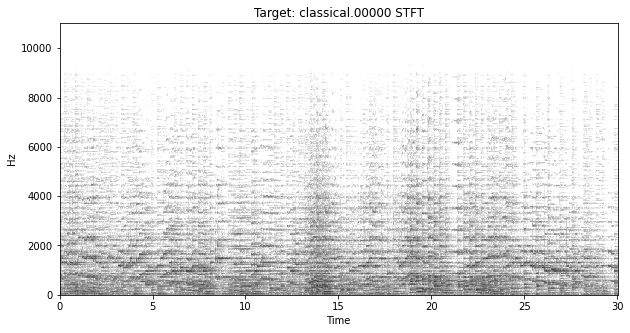

In [19]:
# example
y, sr = librosa.load(targets[0])
D = np.abs(librosa.stft(normalise(y), n_fft=1024, window='hann', win_length=1024, hop_length=512))
plt.figure(figsize=(10,5))
plt.xlabel('sample number')
plt.ylabel('frequency bins')
plt.title(f'Target: {get_file_name(targets[0])} STFT')

librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear',
                        x_axis='time', cmap='gray_r', sr=sr)
fig = plt.gcf()
# fig.savefig('target stft.png')

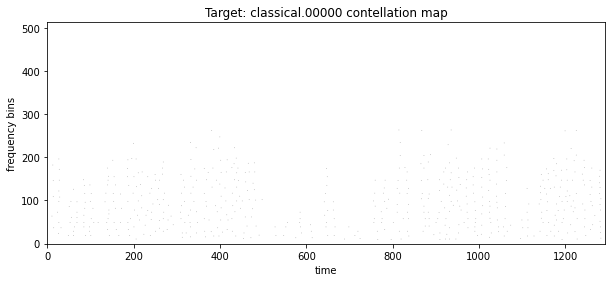

In [20]:
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('frequency bins')
plt.title(f'Target: {get_file_name(targets[0])} contellation map')

plt.imshow(coordinates_targets[5], cmap=plt.cm.gray_r, origin='lower')
fig = plt.gcf()
# fig.savefig('target contellation map.png')

### Database Hash Audio Fingerprint Generation

In [21]:
anchor_distance = 5
fanout = 28
target_address = dict()

def generate_target_hash(coordinates_targets, fanout=30, anchor_distance=10):
    target_address = dict()
    for song_id, coordinates in enumerate(coordinates_targets):
        print(f'Generating Hash {song_id+1}/{len(targets)}...')
        contellation = np.where(coordinates.T==True)
        for i in range(len(contellation[0]) - fanout - anchor_distance + 1):
            anchor_time = contellation[0][i]
            anchor_frequency = contellation[1][i]
            for j in range(fanout):
                time = contellation[0][i+j+anchor_distance]
                frequency = contellation[1][i+j+anchor_distance]
                hash_ = hashlib.sha256(str((anchor_frequency, frequency, time - anchor_time)).encode()).hexdigest()
                if target_address.__contains__(hash_):
                    value = target_address[hash_]
                    value.append((anchor_time, song_id))
                    target_address.update({hash_:value})
                else:
                    target_address.update({hash_:[(anchor_time, song_id)]})
    return target_address


In [22]:
target_address = generate_target_hash(coordinates_targets,fanout=fanout, anchor_distance=anchor_distance)

Generating Hash 1/12...
Generating Hash 2/12...
Generating Hash 3/12...
Generating Hash 4/12...
Generating Hash 5/12...
Generating Hash 6/12...
Generating Hash 7/12...
Generating Hash 8/12...
Generating Hash 9/12...
Generating Hash 10/12...
Generating Hash 11/12...
Generating Hash 12/12...


In [23]:
with open(os.path.join(fingerprintDir,'target_address.data'), 'wb') as f:
    pickle.dump(target_address, f)

### Query Contellation Map Generation

In [24]:
coordinates_query = []
for i, q in enumerate(queries):
    stft = calculate_stft(q)
    coordinates_query.append(calculate_contellation_map(stft,min_distance=min_distance, threshold_rel=threshold_rel))
    print(f'contellation_map {i+1}/{len(queries)}')

contellation_map 1/1


<ipython-input-17-8baa6068428e>:17: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coordinates = peak_local_max(np.log(D), min_distance=min_distance, threshold_rel=threshold_rel, indices=False)


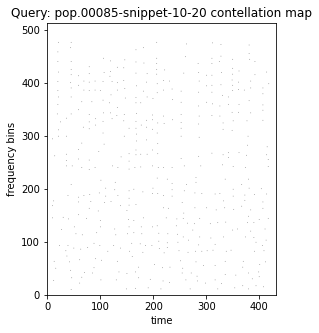

In [25]:
# example
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('frequency bins')
plt.title(f'Query: {get_file_name(queries[0])} contellation map')
plt.imshow(coordinates_query[0], cmap=plt.cm.gray_r, origin='lower')
fig = plt.gcf()

### Start Audio Identification and Evaluation

In [26]:
with open(os.path.join(fingerprintDir,'target_address.data'), 'rb') as f:
    print(f'Loading fingerprints(target_address.data) in folder \'{fingerprintDir}\'...')
    target_address = pickle.load(f)

Loading fingerprints(target_address.data) in folder 'fingerprint'...


In [27]:
# evaluation
def relevance_function(rank_data, queries):
    relevance = []
    for data in rank_data:
        if get_file_name(targets[data[0]]) == queries:
            relevance.append(1)
        else:
            relevance.append(0)
    return np.array(relevance)


def get_precision(rank, relevance):
    precision = []
    for r in range(len(rank)):
        sigma = 0.0
        for r in range(r+1):
            sigma += relevance[r]
        precision.append(sigma/(r+1))
    return np.array(precision)

def get_recall(rank, relevance):
    recall = []
    
    for r in range(len(rank)):
        sigma = 0.0
        for r in range(r+1):
            sigma += relevance[r]
        recall.append(sigma/len(relevance[relevance==1]))
    return np.nan_to_num(np.array(recall))

def f_measure(rank, relevance):
    precision = get_precision(rank, relevance)
    recall = get_recall(rank, relevance)
    f = 2 * precision * recall / (precision + recall)
    return np.nan_to_num(f)

def MAP(rank, relevance):
    precision = get_precision(rank, relevance)
    p_hat_q = []
    for r in range(len(rank)):
        sigma = 0.0
        for r in range(r+1):
            sigma += relevance[r] * precision[r]
        p_hat_q.append(sigma/len(relevance[relevance==1]))
        
    p_hat = np.array(p_hat_q).mean()
    
    return np.nan_to_num(p_hat)

def max_f_measure(rank, relevance):
    f = f_measure(rank, relevance)
    return np.array(f).max()

def break_even_point(rank, relevance):
    precision = np.array(get_precision(rank, relevance))
    recall = np.array(get_recall(rank, relevance))
    index = np.where(precision == recall)
    return index, precision[index]

In [28]:
def generate_query_hash(coordinates_query, fanout=30, anchor_distance=10):
    for query_id, coordinates in enumerate(coordinates_query):
        print(f'Generating Query Hash {query_id+1}/{len(queries)}...')
        query_address = []
        contellation = np.where(coordinates.T==True)
        for i in range(len(contellation[0]) - fanout - anchor_distance + 1):
            anchor_time = contellation[0][i]
            anchor_frequency = contellation[1][i]
            for j in range(fanout):
                time = contellation[0][i+j+anchor_distance]
                frequency = contellation[1][i+j+anchor_distance]
                hash_ = hashlib.sha256(str((anchor_frequency, frequency, time - anchor_time)).encode()).hexdigest()
                query_address.append((anchor_time, hash_))
        yield query_address

def finger_match(coordinates_query, target_address, fanout=30, anchor_distance=10, top=3, evaluation=False, output_path =None):
    maps_query = []
    max_f_query = []
    if output_path:
        with open(output_path,'w+') as f:
            content = ''
            f.writelines(content)
            
    for query_id, query_list in enumerate(generate_query_hash(coordinates_query)):
        print(f'Query: {get_file_name(queries[query_id])}')
        cur_queries = answers[get_file_name(queries[query_id])]
                
        if len(query_list) == 0:
            if evaluation:
                maps_query.append(0)
                max_f_query.append(0)
            if output_path:
                with open(output_path,'a') as f:
                    content = f'{cur_queries}.wav\tno matches\n'
                    f.writelines(content)
            print('Sorry, the query finger is empty\n')
            continue

        indicator = dict() 

        for item in query_list:
            n, h = item
            if target_address.__contains__(h):
                l = np.array(target_address[h])
                time = np.dstack(l)[0][0] - n
                song_id = np.dstack(l)[0][1]
                keys = np.dstack((time, song_id))[0]
                for key in keys:
                    key = tuple(key)
                    if indicator.__contains__(key):
                        indicator.update({key: indicator[key]+1})
                    else:
                        indicator.update({key: 1})
        # results = sorted(indicator.items(), key=lambda x:x[1], reverse=True)
        # print(f'Results: {indicator.items()}\n')
        # filter(lambda x: x>=4, indicator)
        result_table = dict()
        for item in indicator.items():
            song_id = item[0][1]
            count_number = item[1]
            if result_table.__contains__(song_id):             
                result_table.update({song_id: result_table[song_id]+count_number})
            else:
                result_table.update({song_id: count_number})
        results = sorted(result_table.items(), key=lambda x:x[1], reverse=True)
        res = []
        for result in results[:top]:
            res.append(get_file_name(targets[result[0]]))
        print()
        print('Best Match: ')  
        print('=>')
        print(res)
        # print(results[:top])
        
        if output_path:
            res1 = get_file_name(targets[results[0][0]])
            res2 = get_file_name(targets[results[1][0]])
            res3 = get_file_name(targets[results[2][0]])
            with open(output_path,'a') as f:
                content = f'{cur_queries}.wav\t{res1}.wav\t{res3}.wav\t{res3}.wav\n'
                f.writelines(content)
        if evaluation:
            relevance = relevance_function(results, cur_queries)
            map_ = MAP(results[:top], relevance)
            maps_query.append(map_)    

            fmax = max_f_measure(results[:top], relevance)
            max_f_query.append(fmax)

    return maps_query, max_f_query

In [29]:
maps_query, max_f_query = finger_match(coordinates_query, target_address, fanout=fanout, anchor_distance=anchor_distance,top=int(1e100), evaluation=True)

Generating Query Hash 1/1...
Query: pop.00085-snippet-10-20

Best Match: 
=>
['pop.00085', 'pop.00086', 'pop.00084', 'classical.00000', 'classical.00004', 'classical.00002', 'classical.00008', 'classical.00001', 'classical.00003', 'classical.00005', 'classical.00007', 'classical.00006']


In [30]:
print('mAP: ',maps_query)
print('max f:', max_f_query)

mAP:  [1.0]
max f: [1.0]
